# Blood Vessel Extraction in Retinal Fundus Images

## Importing the libraries

Importing libraries for the project, most of them are related to image analysis to take advantage of consolidated functions which give good results and are less time consuming.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import frangi
from sklearn.cluster import KMeans
import os
from skimage.morphology import remove_small_objects
import warnings
from skimage.metrics import structural_similarity as ssim
warnings.filterwarnings("ignore")

In [2]:
def eliminate_ticks():
    plt.tick_params(left = False, labelleft = False , bottom = False, labelbottom = False)

## Selection and expansion of ROIs

Retinal region masks must be utilized in order to select the region of interest in fundus images

##### ROI selector with two thresholds

Two thresholds are used to obtain the mask for the ROI:
- Considering the **mean value** of the three channels. It has to be lower than 40.
- Considering the **absolute of the difference** between channels with a threshold of 50.

In [3]:
def ROI_Selector(img):
    '''
    Parameters
    ----------
    img : Eye fundus image in RGB format

    Returns
    -------
    A binary mask selecting just the retina and eliminating the background
    '''
    imR,imG,imB=img[:,:,0],img[:,:,1],img[:,:,2]
    im_bo=np.copy(imR)
    rows,cols=imR.shape
    for ii in range(rows):
        for jj in range(cols):
            c1=np.mean([imR[ii,jj],imG[ii,jj],imB[ii,jj]])<40 #first threshold
            c2=np.abs(imR[ii,jj]-imG[ii,jj])+np.abs(imR[ii,jj]-imB[ii,jj])+np.abs(imG[ii,jj]-imB[ii,jj])<50 #second threshold
            if c1 and c2:
                im_bo[ii,jj]=1
            else:
                im_bo[ii,jj]=0
    return im_bo

## Gray Level Conversion
##### Converting three channels into a unique channel
For the conversion,
I have selected the color channel coefficients as cr = 0.1, cg = 0.7,
and cb = 0.2 by using a training set from image databases. The green channel has more weight than the other RGB channels.

In [4]:
def GrayLevelConverter(img):
    '''
    Parameters
    ----------
    img : Eye fundus image in RGB format (3 channels)

    Returns
    -------
    I : Eye fundus image in gray level format (1 channel)
    '''
    imR,imG,imB=img[:,:,0],img[:,:,1],img[:,:,2]
    cr=0.1
    cg=0.7
    cb=0.2
    I = cr * imR + cg * imG + cb * imB
    return I

## Vessel Light Reflex Removal
To remove vessel light reflex effect (white reflexes on the retinal vessels), a gray level morphological opening operation is applied to the intensity image with three-pixel diameter disk obtaining blood vessels without a white line in the center, enhancing the performance of the algorithm.

In [5]:
def GrayLevelOpening(img):
    '''
    Parameters
    ----------
    img : Eye fundus image in gray level format
    Returns
    -------
    The image with Vessel Light Reflex removed

    '''
    kernel=np.ones((3,3))
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

## Frangi Filter

Later, I have used the Frangi filter from `skimage.filter` so as to obtain an image with its retinal vessels enhanced (leading to an easier discrimination of them).

In [6]:
def Frangi(img):
    '''
    Returns the image after applying the Frangi filter
    '''
    return frangi(img,sigmas=range(1, 20, 25),black_ridges=True,gamma=3.5)

## Tophat application
In this study, the top-hat transform is applied to the output of the Frangi filter. In the application, the structuring element size is 5 pixels (n = 5) with disk shape.

In [7]:
def TopHat(img):
    '''
    Parameters
    ----------
    img : Gray level image after the application of enhancement filters

    Returns
    -------
    Image with the top-hat transform applied
    '''
    kernel=np.ones((5,5))
    return cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)

## Kmeans

After the feature
extraction stage, the binary vessel map must be obtained. 
To achieve it, a clustering method which classifies the pixels as vessel or nonvessel
is implemented. More precisely, the kmeans algorithm is used with 3 clusters to later divide them in the vessel (1 cluster) and non-vessel (rest of the clusters) classes.

In [8]:
def kmeans(img,n_clusters):
    '''
    Parameters
    ----------
    img : Processed image
    n_clusters : Number of clusters used by K-means

    Returns
    -------
    Binary image with vessels marked as 1 and background marked as 0
    '''
    M,N,Ch=img.shape
    dataK1=img[:,:,0].flatten()
    dataK2=img[:,:,1].flatten()
    dataK3=img[:,:,2].flatten()
    dataK=np.array([dataK1,dataK2,dataK3]).T
    knn=KMeans(n_clusters=n_clusters,init='k-means++',random_state=0).fit(dataK)
    labels=knn.predict(dataK)
    iRes=np.reshape(labels,(M,N))
    # Converting all the labels greater than 1 to 1 (vessel)
    ires=np.where(iRes > 1, 1, iRes) 
    return ires.astype('uint8')

## Post-processing

A post-processing method consisting on the removal of small clusters (lower than 14 pixels) is applied to omit noise at the resulting image. The `remove_small_objects` from skimage is applied to solve this problem.

In [9]:
def postprocess(img):
    '''
    It removes small clusters (lower than 14 pixels)
    '''
    return remove_small_objects(np.array(img, bool), min_size = 14)

## Trying the code for several pictures

To try the code for several pictures easily, I have created a main function to include all the steps in one.

In [10]:
def vessels(img, n_clusters):
    '''
    Main function which has as parameters:
    ----------
    img : RGB image to segment
    n_clusters : Number of clusters used by the clustering algorithm

    and returns
    -------
    A binary map of the vessels of the introduced image
    '''
    cm=plt.get_cmap("viridis")
    img_dilation_roi=cv2.dilate(ROI_Selector(img),np.ones((6,6)))
    mask_inv=np.where((img_dilation_roi==0)|(img_dilation_roi==1), img_dilation_roi^1, img_dilation_roi)
    stdy_img=GrayLevelOpening(GrayLevelConverter(img))
    defi=TopHat(Frangi(stdy_img))
    defi=cm(defi)
    kernel=np.ones((3,3))
    return cv2.dilate(postprocess(kmeans(defi,n_clusters))*mask_inv,kernel)

## Trial of the created function

To try the created function, images from the [DRIVE](https://drive.grand-challenge.org/) dataset were used.

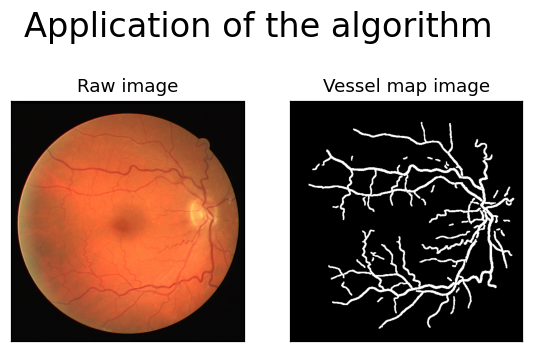

In [11]:
# Example for one image
im_def=plt.imread("training/images/22_training.jpg")

plt.figure(1,dpi=110)
plt.suptitle("Application of the algorithm",size=22)
plt.subplot(1,2,1)
plt.imshow(im_def)
plt.title("Raw image")
eliminate_ticks()
plt.subplot(1,2,2)
plt.title("Vessel map image")
plt.imshow(vessels(im_def,4), cmap='gray')
eliminate_ticks()
plt.show()

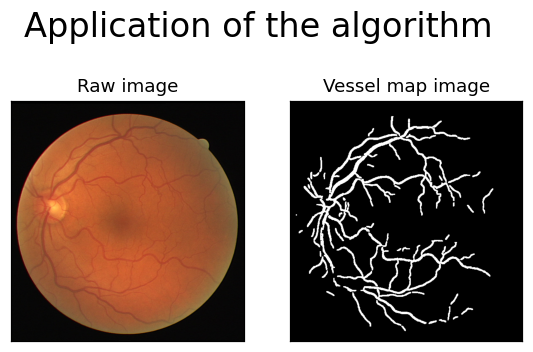

In [12]:
# Example for one image
im_def=plt.imread("training/images/39_training.jpg")

plt.figure(1,dpi=110)
plt.suptitle("Application of the algorithm",size=22)
plt.subplot(1,2,1)
plt.imshow(im_def)
plt.title("Raw image")
eliminate_ticks()
plt.subplot(1,2,2)
plt.title("Vessel map image")
plt.imshow(vessels(im_def,4), cmap='gray')
eliminate_ticks()
plt.show()